In [1]:
!date

Wed Jul 28 12:15:07 PDT 2021


# Class DE isoform hidden by gene

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/home/nmarkari/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
subclass_cmap = pd.read_csv('../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='subclass_label',usecols=['subclass_label','subclass_color'])
subclass_cmap = subclass_cmap.drop_duplicates()
subclass_cmap = subclass_cmap.subclass_color.apply(lambda x: mcolors.to_rgb(x) )
subclass_cmap = subclass_cmap.to_dict()

In [4]:
subclass_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [5]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [6]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [7]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

In [8]:
print(isoform.shape)
print(gene.shape)

(18175, 81527)
(18175, 26154)


In [9]:
gene.obs.subclass_label.value_counts()

DG               2413
CA1-ProS         1631
Lamp5            1424
Vip              1352
Sst              1213
L4/5 IT CTX      1000
L2/3 IT CTX       884
L6 CT CTX         849
Sncg              720
L6b/CT ENT        638
Pvalb             619
L6 IT CTX         603
L3 IT ENT         574
L2/3 IT PPP       491
SUB-ProS          453
Car3              418
L5 NP CTX         320
L2/3 IT ENTl      318
CA3               302
L5 IT CTX         283
L5 IT TPE-ENT     260
NP SUB            242
L2  IT ENTl       178
Astro             132
L2/3 IT RHP       129
L6b CTX           128
CT SUB            121
L5 PT CTX          96
L4 RSP-ACA         78
L6 IT ENTl         74
Meis2              65
L2 IT ENTm         41
Sst Chodl          35
NP PPP             29
Micro-PVM          28
IG-FC              18
L5 PPP              9
Oligo               5
CR                  2
Name: subclass_label, dtype: int64

In [10]:
regions = gene.obs.region_label.unique()
subclasss = gene.obs.subclass_label.unique()
breakdown = pd.DataFrame(index=subclasss, columns=regions)
for region in regions:
    m = gene.obs.region_label == region
    r = gene.obs[m]
    d = r.subclass_label.value_counts()
    d = d.to_dict()
    breakdown[region] = breakdown.index.map(d)
breakdown

,HIP,ORB,ENTm,ENTl,SUB-ProS,AI,PL-ILA,TEa-PERI-ECT,RSP
CA1-ProS,1520,0,0,2,109,0,0,0,0
DG,2413,0,0,0,0,0,0,0,0
CA3,302,0,0,0,0,0,0,0,0
IG-FC,18,0,0,0,0,0,0,0,0
L2/3 IT RHP,5,0,18,16,90,0,0,0,0
NP SUB,9,0,0,0,233,0,0,0,0
SUB-ProS,31,0,0,1,421,0,0,0,0
L6 CT CTX,2,104,2,3,27,166,179,294,72
L6b CTX,1,8,14,19,17,12,10,46,1
L2/3 IT ENTl,2,1,50,259,0,5,0,1,0


In [11]:
c = 3 #minimum number of columns that must satisfy criteria
n = 40 #minimum number of cells
b = breakdown.applymap(lambda x: x >=n)
for region in regions:
    b[region] = b[region].map({True:1,False:0})
m2 = b.sum(axis=1) >= c
f_breakdown =breakdown[m2]
f_breakdown

,HIP,ORB,ENTm,ENTl,SUB-ProS,AI,PL-ILA,TEa-PERI-ECT,RSP
L6 CT CTX,2,104,2,3,27,166,179,294,72
Lamp5,834,56,95,65,25,94,65,95,95
Sncg,371,25,45,60,68,39,55,29,28
Sst,267,75,126,76,218,77,147,84,143
Vip,448,111,72,103,102,106,128,89,193
Pvalb,64,22,93,79,82,67,76,80,56
L4/5 IT CTX,0,278,0,28,1,188,228,141,136
L2/3 IT CTX,0,324,1,13,0,159,193,89,105
L5 IT CTX,0,102,0,0,0,15,56,20,90
L6 IT CTX,0,102,9,6,1,174,98,110,103


In [12]:
def gene_dexpress(c_gene):
    mat           = c_gene.layers["log1p"].todense()
    components    = c_gene.obs.cell_id.values
    features      = c_gene.var.gene_name.values
    assignments   = c_gene.obs.region_label.values

    unique = np.unique(assignments)
    nan_cutoff = 0.9 # of elements in subclass
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
    markers_gene = markers_gene.query("es > 0")
    return markers_gene

In [13]:
def isoform_dexpress(c_isoform):
    mat         = c_isoform.layers["log1p"].todense() # expects dense matrix
    components  = c_isoform.obs.cell_id.values
    features    = c_isoform.var.transcript_name.values
    assignments = c_isoform.obs.region_label.values

    unique = np.unique(assignments)
    nan_cutoff = 0.9 # of elements in subclass
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
    markers_isoform = markers_isoform.query("es > 0")
    return markers_isoform

In [14]:
f_breakdown.index

CategoricalIndex(['L6 CT CTX', 'Lamp5', 'Sncg', 'Sst', 'Vip', 'Pvalb',
                  'L4/5 IT CTX', 'L2/3 IT CTX', 'L5 IT CTX', 'L6 IT CTX',
                  'L5 NP CTX'],
                 categories=['CA1-ProS', 'DG', 'CA3', 'IG-FC', 'L2/3 IT RHP', 'NP SUB', 'SUB-ProS', 'L6 CT CTX', ...], ordered=False, dtype='category')

In [15]:
f_breakdown.index[3]

'Sst'

In [16]:
#markers_gene = pd.DataFrame(columns=['index','name','p_raw','p_corr','es','index_name','subclass'])
#markers_isoform = pd.DataFrame(columns=['index','name','p_raw','p_corr','es','index_name','subclass'])
#for subclass in f_breakdown.index:
#    mask = np.logical_and(gene.obs.subclass_label == subclass, np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic"))
#    c_gene = gene[mask]
#    c_isoform = isoform[mask]
#    temp_gene = gene_dexpress(c_gene)
#    temp_gene['subclass'] = subclass
#    markers_gene = pd.concat([markers_gene,temp_gene])
#    temp_isoform = isoform_dexpress(c_isoform)
#    temp_isoform['subclass'] = subclass
#    markers_isoform = pd.concat([markers_isoform,temp_isoform])
    

28-Jul-21 12:15:28 - 1 of 9 assignments: AI
28-Jul-21 12:15:29 - 2 of 9 assignments: ENTl
28-Jul-21 12:15:29 - 3 of 9 assignments: ENTm
28-Jul-21 12:15:29 - 4 of 9 assignments: HIP
28-Jul-21 12:15:29 - 5 of 9 assignments: ORB
28-Jul-21 12:15:29 - 6 of 9 assignments: PL-ILA
28-Jul-21 12:15:30 - 7 of 9 assignments: RSP
28-Jul-21 12:15:30 - 8 of 9 assignments: SUB-ProS
28-Jul-21 12:15:30 - 9 of 9 assignments: TEa-PERI-ECT
28-Jul-21 12:15:33 - 1 of 9 assignments: AI
28-Jul-21 12:15:33 - 2 of 9 assignments: ENTl
28-Jul-21 12:15:33 - 3 of 9 assignments: ENTm
28-Jul-21 12:15:34 - 4 of 9 assignments: HIP
28-Jul-21 12:15:35 - 5 of 9 assignments: ORB
28-Jul-21 12:15:35 - 6 of 9 assignments: PL-ILA
28-Jul-21 12:15:35 - 7 of 9 assignments: RSP
28-Jul-21 12:15:36 - 8 of 9 assignments: SUB-ProS
28-Jul-21 12:15:36 - 9 of 9 assignments: TEa-PERI-ECT
28-Jul-21 12:15:38 - 1 of 9 assignments: AI
28-Jul-21 12:15:38 - 2 of 9 assignments: ENTl
28-Jul-21 12:15:39 - 3 of 9 assignments: ENTm
28-Jul-21 12:15:39

In [17]:
%%time
subclasss = np.sort(isoform.obs.subclass_label.unique())
n_cells = 50

de_Regionsubclasss = []
de_genes = []
de_isoforms = []

for cidx, c in enumerate(subclasss):
    print(f"{cidx+1} of {len(subclasss)}: {c}")
    tmp_isoform = isoform[isoform.obs.eval(f"subclass_label == '{c}'")].copy()
    tmp_gene    = gene[gene.obs.eval(f"subclass_label == '{c}'")].copy()
    
    big_enough_Regionsubclasss = tmp_gene.obs["region_label"].value_counts()[tmp_gene.obs["region_label"].value_counts()>n_cells].index.values
    if len(big_enough_Regionsubclasss) > 1:
        tmp_isoform = tmp_isoform[tmp_isoform.obs["region_label"].isin(big_enough_Regionsubclasss)].copy()
        tmp_gene = tmp_gene[tmp_gene.obs["region_label"].isin(big_enough_Regionsubclasss)].copy()
   
            
        de_Regionsubclasss.append(c)
        ####### Genes
        mat           = tmp_gene.layers["log1p"].todense()
        components    = tmp_gene.obs.cell_id.values
        features      = tmp_gene.var.gene_name.values
        assignments   = tmp_gene.obs.region_label.values

        # parameters
        unique        = np.unique(assignments)
        nan_cutoff    = 0.9 # of elements in region
        corr_method   = "bonferroni"

        p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
        p_corr = utils.correct_pvals(p_raw)#, nfeat, corr_method)

        s = stat

        markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

        # convert the 0 pvalues to the smallest possible float
        markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
        markers_gene["subclass"]=c
        markers_gene["n_isoforms"] = markers_gene.name.map(gene.var.num_isoforms)
        de_genes.append(markers_gene)



        ######### Isoforms
        mat           = tmp_isoform.layers["log1p"].todense()
        components    = tmp_isoform.obs.cell_id.values
        features      = tmp_isoform.var.transcript_name.values
        assignments   = tmp_isoform.obs.region_label.values

        # parameters
        unique        = np.unique(assignments)
        nan_cutoff    = 0.9 # of elements in region
        corr_method   = "bonferroni"


        p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
        p_corr = utils.correct_pvals(p_raw)#, nfeat, corr_method)

        s = stat

        markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)
        #nick: bonferroni didn't work for some reason, doing it manually
        num_tests = len(markers_isoform['index'].unique())
        markers_isoform['p_corr'] = markers_isoform['p_raw'].apply(lambda x: x*num_tests)
        num_tests = len(markers_gene['index'].unique())
        markers_gene['p_corr'] = markers_gene['p_raw'].apply(lambda x: x*num_tests)
        #end nick
        # convert the 0 pvalues to the smallest possible float
        markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
        markers_isoform["subclass"]=c
        de_isoforms.append(markers_isoform)

1 of 39: Astro
2 of 39: CA1-ProS


28-Jul-21 12:17:05 - 1 of 2 assignments: HIP
28-Jul-21 12:17:06 - 2 of 2 assignments: SUB-ProS
28-Jul-21 12:17:07 - 1 of 2 assignments: HIP
28-Jul-21 12:17:08 - 2 of 2 assignments: SUB-ProS


3 of 39: CA3
4 of 39: CR
5 of 39: CT SUB
6 of 39: Car3


28-Jul-21 12:17:12 - 1 of 2 assignments: AI
28-Jul-21 12:17:12 - 2 of 2 assignments: TEa-PERI-ECT
28-Jul-21 12:17:13 - 1 of 2 assignments: AI
28-Jul-21 12:17:13 - 2 of 2 assignments: TEa-PERI-ECT


7 of 39: DG
8 of 39: IG-FC
9 of 39: L2  IT ENTl
10 of 39: L2 IT ENTm
11 of 39: L2/3 IT CTX


28-Jul-21 12:17:26 - 1 of 5 assignments: AI
28-Jul-21 12:17:27 - 2 of 5 assignments: ORB
28-Jul-21 12:17:27 - 3 of 5 assignments: PL-ILA
28-Jul-21 12:17:27 - 4 of 5 assignments: RSP
28-Jul-21 12:17:27 - 5 of 5 assignments: TEa-PERI-ECT
28-Jul-21 12:17:29 - 1 of 5 assignments: AI
28-Jul-21 12:17:29 - 2 of 5 assignments: ORB
28-Jul-21 12:17:29 - 3 of 5 assignments: PL-ILA
28-Jul-21 12:17:29 - 4 of 5 assignments: RSP
28-Jul-21 12:17:30 - 5 of 5 assignments: TEa-PERI-ECT


12 of 39: L2/3 IT ENTl
13 of 39: L2/3 IT PPP


28-Jul-21 12:17:34 - 1 of 2 assignments: ENTm
28-Jul-21 12:17:34 - 2 of 2 assignments: RSP
28-Jul-21 12:17:34 - 1 of 2 assignments: ENTm
28-Jul-21 12:17:35 - 2 of 2 assignments: RSP


14 of 39: L2/3 IT RHP
15 of 39: L3 IT ENT


28-Jul-21 12:17:38 - 1 of 2 assignments: ENTl
28-Jul-21 12:17:38 - 2 of 2 assignments: ENTm
28-Jul-21 12:17:39 - 1 of 2 assignments: ENTl
28-Jul-21 12:17:39 - 2 of 2 assignments: ENTm


16 of 39: L4 RSP-ACA
17 of 39: L4/5 IT CTX


28-Jul-21 12:17:45 - 1 of 5 assignments: AI
28-Jul-21 12:17:45 - 2 of 5 assignments: ORB
28-Jul-21 12:17:45 - 3 of 5 assignments: PL-ILA
28-Jul-21 12:17:45 - 4 of 5 assignments: RSP
28-Jul-21 12:17:45 - 5 of 5 assignments: TEa-PERI-ECT
28-Jul-21 12:17:47 - 1 of 5 assignments: AI
28-Jul-21 12:17:47 - 2 of 5 assignments: ORB
28-Jul-21 12:17:48 - 3 of 5 assignments: PL-ILA
28-Jul-21 12:17:48 - 4 of 5 assignments: RSP
28-Jul-21 12:17:48 - 5 of 5 assignments: TEa-PERI-ECT


18 of 39: L5 IT CTX


28-Jul-21 12:17:51 - 1 of 3 assignments: ORB
28-Jul-21 12:17:51 - 2 of 3 assignments: PL-ILA
28-Jul-21 12:17:51 - 3 of 3 assignments: RSP
28-Jul-21 12:17:51 - 1 of 3 assignments: ORB
28-Jul-21 12:17:51 - 2 of 3 assignments: PL-ILA
28-Jul-21 12:17:51 - 3 of 3 assignments: RSP


19 of 39: L5 IT TPE-ENT


28-Jul-21 12:17:53 - 1 of 2 assignments: ENTl
28-Jul-21 12:17:53 - 2 of 2 assignments: TEa-PERI-ECT
28-Jul-21 12:17:54 - 1 of 2 assignments: ENTl
28-Jul-21 12:17:54 - 2 of 2 assignments: TEa-PERI-ECT


20 of 39: L5 NP CTX


28-Jul-21 12:17:55 - 1 of 4 assignments: AI
28-Jul-21 12:17:55 - 2 of 4 assignments: PL-ILA
28-Jul-21 12:17:55 - 3 of 4 assignments: RSP
28-Jul-21 12:17:55 - 4 of 4 assignments: TEa-PERI-ECT
28-Jul-21 12:17:56 - 1 of 4 assignments: AI
28-Jul-21 12:17:56 - 2 of 4 assignments: PL-ILA
28-Jul-21 12:17:56 - 3 of 4 assignments: RSP
28-Jul-21 12:17:56 - 4 of 4 assignments: TEa-PERI-ECT


21 of 39: L5 PPP
22 of 39: L5 PT CTX
23 of 39: L6 CT CTX


28-Jul-21 12:18:01 - 1 of 5 assignments: AI
28-Jul-21 12:18:01 - 2 of 5 assignments: ORB
28-Jul-21 12:18:02 - 3 of 5 assignments: PL-ILA
28-Jul-21 12:18:02 - 4 of 5 assignments: RSP
28-Jul-21 12:18:02 - 5 of 5 assignments: TEa-PERI-ECT
28-Jul-21 12:18:03 - 1 of 5 assignments: AI
28-Jul-21 12:18:03 - 2 of 5 assignments: ORB
28-Jul-21 12:18:04 - 3 of 5 assignments: PL-ILA
28-Jul-21 12:18:04 - 4 of 5 assignments: RSP
28-Jul-21 12:18:04 - 5 of 5 assignments: TEa-PERI-ECT


24 of 39: L6 IT CTX


28-Jul-21 12:18:08 - 1 of 5 assignments: AI
28-Jul-21 12:18:08 - 2 of 5 assignments: ORB
28-Jul-21 12:18:08 - 3 of 5 assignments: PL-ILA
28-Jul-21 12:18:08 - 4 of 5 assignments: RSP
28-Jul-21 12:18:08 - 5 of 5 assignments: TEa-PERI-ECT
28-Jul-21 12:18:09 - 1 of 5 assignments: AI
28-Jul-21 12:18:10 - 2 of 5 assignments: ORB
28-Jul-21 12:18:10 - 3 of 5 assignments: PL-ILA
28-Jul-21 12:18:10 - 4 of 5 assignments: RSP
28-Jul-21 12:18:10 - 5 of 5 assignments: TEa-PERI-ECT


25 of 39: L6 IT ENTl
26 of 39: L6b CTX
27 of 39: L6b/CT ENT


28-Jul-21 12:18:14 - 1 of 2 assignments: ENTl
28-Jul-21 12:18:14 - 2 of 2 assignments: ENTm
28-Jul-21 12:18:15 - 1 of 2 assignments: ENTl
28-Jul-21 12:18:15 - 2 of 2 assignments: ENTm


28 of 39: Lamp5


28-Jul-21 12:18:22 - 1 of 8 assignments: AI
28-Jul-21 12:18:23 - 2 of 8 assignments: ENTl
28-Jul-21 12:18:23 - 3 of 8 assignments: ENTm
28-Jul-21 12:18:23 - 4 of 8 assignments: HIP
28-Jul-21 12:18:23 - 5 of 8 assignments: ORB
28-Jul-21 12:18:23 - 6 of 8 assignments: PL-ILA
28-Jul-21 12:18:23 - 7 of 8 assignments: RSP
28-Jul-21 12:18:24 - 8 of 8 assignments: TEa-PERI-ECT
28-Jul-21 12:18:26 - 1 of 8 assignments: AI
28-Jul-21 12:18:26 - 2 of 8 assignments: ENTl
28-Jul-21 12:18:27 - 3 of 8 assignments: ENTm
28-Jul-21 12:18:27 - 4 of 8 assignments: HIP
28-Jul-21 12:18:28 - 5 of 8 assignments: ORB
28-Jul-21 12:18:28 - 6 of 8 assignments: PL-ILA
28-Jul-21 12:18:28 - 7 of 8 assignments: RSP
28-Jul-21 12:18:29 - 8 of 8 assignments: TEa-PERI-ECT


29 of 39: Meis2
30 of 39: Micro-PVM
31 of 39: NP PPP
32 of 39: NP SUB
33 of 39: Oligo
34 of 39: Pvalb


28-Jul-21 12:18:34 - 1 of 8 assignments: AI
28-Jul-21 12:18:34 - 2 of 8 assignments: ENTl
28-Jul-21 12:18:34 - 3 of 8 assignments: ENTm
28-Jul-21 12:18:34 - 4 of 8 assignments: HIP
28-Jul-21 12:18:35 - 5 of 8 assignments: PL-ILA
28-Jul-21 12:18:35 - 6 of 8 assignments: RSP
28-Jul-21 12:18:35 - 7 of 8 assignments: SUB-ProS
28-Jul-21 12:18:35 - 8 of 8 assignments: TEa-PERI-ECT
28-Jul-21 12:18:37 - 1 of 8 assignments: AI
28-Jul-21 12:18:37 - 2 of 8 assignments: ENTl
28-Jul-21 12:18:37 - 3 of 8 assignments: ENTm
28-Jul-21 12:18:37 - 4 of 8 assignments: HIP
28-Jul-21 12:18:37 - 5 of 8 assignments: PL-ILA
28-Jul-21 12:18:37 - 6 of 8 assignments: RSP
28-Jul-21 12:18:38 - 7 of 8 assignments: SUB-ProS
28-Jul-21 12:18:38 - 8 of 8 assignments: TEa-PERI-ECT


35 of 39: SUB-ProS
36 of 39: Sncg


28-Jul-21 12:18:43 - 1 of 4 assignments: ENTl
28-Jul-21 12:18:43 - 2 of 4 assignments: HIP
28-Jul-21 12:18:43 - 3 of 4 assignments: PL-ILA
28-Jul-21 12:18:43 - 4 of 4 assignments: SUB-ProS
28-Jul-21 12:18:44 - 1 of 4 assignments: ENTl
28-Jul-21 12:18:45 - 2 of 4 assignments: HIP
28-Jul-21 12:18:45 - 3 of 4 assignments: PL-ILA
28-Jul-21 12:18:45 - 4 of 4 assignments: SUB-ProS


37 of 39: Sst


28-Jul-21 12:18:51 - 1 of 9 assignments: AI
28-Jul-21 12:18:51 - 2 of 9 assignments: ENTl
28-Jul-21 12:18:51 - 3 of 9 assignments: ENTm
28-Jul-21 12:18:52 - 4 of 9 assignments: HIP
28-Jul-21 12:18:52 - 5 of 9 assignments: ORB
28-Jul-21 12:18:52 - 6 of 9 assignments: PL-ILA
28-Jul-21 12:18:52 - 7 of 9 assignments: RSP
28-Jul-21 12:18:52 - 8 of 9 assignments: SUB-ProS
28-Jul-21 12:18:52 - 9 of 9 assignments: TEa-PERI-ECT
28-Jul-21 12:18:55 - 1 of 9 assignments: AI
28-Jul-21 12:18:55 - 2 of 9 assignments: ENTl
28-Jul-21 12:18:56 - 3 of 9 assignments: ENTm
28-Jul-21 12:18:56 - 4 of 9 assignments: HIP
28-Jul-21 12:18:56 - 5 of 9 assignments: ORB
28-Jul-21 12:18:57 - 6 of 9 assignments: PL-ILA
28-Jul-21 12:18:57 - 7 of 9 assignments: RSP
28-Jul-21 12:18:57 - 8 of 9 assignments: SUB-ProS
28-Jul-21 12:18:58 - 9 of 9 assignments: TEa-PERI-ECT


38 of 39: Sst Chodl
39 of 39: Vip


28-Jul-21 12:19:05 - 1 of 9 assignments: AI
28-Jul-21 12:19:05 - 2 of 9 assignments: ENTl
28-Jul-21 12:19:05 - 3 of 9 assignments: ENTm
28-Jul-21 12:19:05 - 4 of 9 assignments: HIP
28-Jul-21 12:19:05 - 5 of 9 assignments: ORB
28-Jul-21 12:19:05 - 6 of 9 assignments: PL-ILA
28-Jul-21 12:19:06 - 7 of 9 assignments: RSP
28-Jul-21 12:19:06 - 8 of 9 assignments: SUB-ProS
28-Jul-21 12:19:06 - 9 of 9 assignments: TEa-PERI-ECT
28-Jul-21 12:19:08 - 1 of 9 assignments: AI
28-Jul-21 12:19:09 - 2 of 9 assignments: ENTl
28-Jul-21 12:19:09 - 3 of 9 assignments: ENTm
28-Jul-21 12:19:09 - 4 of 9 assignments: HIP
28-Jul-21 12:19:10 - 5 of 9 assignments: ORB
28-Jul-21 12:19:10 - 6 of 9 assignments: PL-ILA
28-Jul-21 12:19:10 - 7 of 9 assignments: RSP
28-Jul-21 12:19:11 - 8 of 9 assignments: SUB-ProS
28-Jul-21 12:19:11 - 9 of 9 assignments: TEa-PERI-ECT


CPU times: user 1min 31s, sys: 44.3 s, total: 2min 16s
Wall time: 2min 15s


In [34]:
markers_gene = pd.concat(de_genes)

markers_isoform = pd.concat(de_isoforms)

In [35]:
#mask = np.logical_and(gene.obs.subclass_label == 'Vip', np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic"))
#mask = (gene.obs.subclass_label == 'Vip')

#c_gene = gene[mask]
#c_isoform = isoform[mask]
#markers_gene= gene_dexpress(c_gene)
#markers_isoform = isoform_dexpress(c_isoform)

# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [36]:
alpha =0.01#/len(f_breakdown.index) #second bonferroni correction for multiple subclasss being tested
fc = 2

relevant_genes = markers_gene.p_corr < alpha

markers_gene["index_name"] = markers_gene["index"] + "_" + markers_gene.name.apply(lambda x: "".join(x.split("_")[:-1]))
markers_isoform["index_name"] = markers_isoform["index"] + "_" + markers_isoform.name.apply(lambda x: "-".join(x.split("-")[:-1]))

setdiff = np.setdiff1d(markers_isoform["index_name"].values, markers_gene[relevant_genes]["index_name"].values)

In [37]:
markers_isoform = markers_isoform[markers_isoform["index_name"].isin(setdiff)].sort_values(["es", "p_corr"])

markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es")[::-1][:20]

,index,name,p_raw,p_corr,es,subclass,index_name
162757,RSP,7SK.188-201_ENSMUST00020183253.1,9.61319e-22,1.922638e-21,3.58267,L2/3 IT PPP,RSP_7SK.188
28420,ENTm,Rps6-204_ENSMUST00000136174.8,1.97427e-29,3.948531e-29,2.65046,L2/3 IT PPP,ENTm_Rps6
66273,ENTm,Rpl31-203_ENSMUST00000179954.8,5.6671e-31,1.133420e-30,2.47776,L2/3 IT PPP,ENTm_Rpl31
12143,ENTm,Gtpbp4-202_ENSMUST00000220546.2,2.15065e-17,4.301299e-17,2.19252,L2/3 IT PPP,ENTm_Gtpbp4
67662,ENTm,Rbis-204_ENSMUST00000186870.7,1.57729e-13,3.154573e-13,1.60859,L2/3 IT PPP,ENTm_Rbis
12145,ENTm,Gtpbp4-201_ENSMUST00000021574.8,1.57792e-27,3.155831e-27,1.60081,L2/3 IT PPP,ENTm_Gtpbp4
7590,ENTm,Zfp207-206_ENSMUST00000165565.8,2.78719e-13,5.574385e-13,1.45228,L2/3 IT PPP,ENTm_Zfp207
488865,RSP,7SK.188-201_ENSMUST00020183253.1,1.38382e-07,1.107055e-06,1.41516,Pvalb,RSP_7SK.188
143738,PL-ILA,Slc25a3-204_ENSMUST00000167455.8,4.04692e-09,1.618769e-08,1.37972,L5 NP CTX,PL-ILA_Slc25a3
325811,RSP,7SK.188-201_ENSMUST00020183253.1,3.02197e-08,1.510986e-07,1.34709,L6 CT CTX,RSP_7SK.188


In [39]:
#markers_gene[np.logical_and(markers_gene.name.str.contains("7SK"),markers_gene.subclass == "L2/3 IT PPP")]
markers_gene[markers_gene.name.str.contains("Rps6")]

,index,name,p_raw,p_corr,es,subclass,n_isoforms,index_name
2143,HIP,Rps6kb1_ENSMUSG00000020516.16,0.116987,0.233974,0.157571,CA1-ProS,7,HIP_Rps6kb1
5534,HIP,Rps6_ENSMUSG00000028495.15,7.55527e-07,0.000002,-0.145169,CA1-ProS,4,HIP_Rps6
28297,SUB-ProS,Rps6kb1_ENSMUSG00000020516.16,0.116987,0.233974,-0.157571,CA1-ProS,7,SUB-ProS_Rps6kb1
31688,SUB-ProS,Rps6_ENSMUSG00000028495.15,7.55527e-07,0.000002,0.145169,CA1-ProS,4,SUB-ProS_Rps6
2143,AI,Rps6kb1_ENSMUSG00000020516.16,0.330179,0.660358,-0.119729,Car3,7,AI_Rps6kb1
...,...,...,...,...,...,...,...,...
162458,RSP,Rps6_ENSMUSG00000028495.15,0.357719,3.219469,-0.031409,Vip,4,RSP_Rps6
172673,RSP,Rps6-ps4_ENSMUSG00000081406.5,0.865997,7.793970,-0.0284197,Vip,1,RSP_Rps6-ps4
188612,SUB-ProS,Rps6_ENSMUSG00000028495.15,0.380387,3.423481,-0.0385668,Vip,4,SUB-ProS_Rps6
198827,SUB-ProS,Rps6-ps4_ENSMUSG00000081406.5,0.293334,2.640007,-0.228917,Vip,1,SUB-ProS_Rps6-ps4


In [44]:
#specific_region = "Glutamatergic"
#specific_gene = "Kifap3_ENSMUSG00000026585.14"
#specific_isoform = "Kifap3-202_ENSMUST00000077642.12"

#specific_region = "ENTl"
specific_region = "ENTm"
specific_gene = "Rps6_ENSMUSG00000028495.15"
specific_isoform = "Rps6-204_ENSMUST00000136174.8"
specific_subclass = 'L2/3 IT PPP'

In [45]:
isoform_f = isoform[isoform.obs.eval(f"subclass_label == '{specific_subclass}'")]
gene_f = gene[gene.obs.eval(f"subclass_label == '{specific_subclass}'")]
#need to filter out subclasses that are too small
big_enough_Regionsubclasss = gene_f.obs["region_label"].value_counts()[gene_f.obs["region_label"].value_counts()>n_cells].index.values
isoform_f = isoform_f[isoform_f.obs["region_label"].isin(big_enough_Regionsubclasss)].copy()
gene_f = gene_f[gene_f.obs["region_label"].isin(big_enough_Regionsubclasss)].copy()

In [46]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


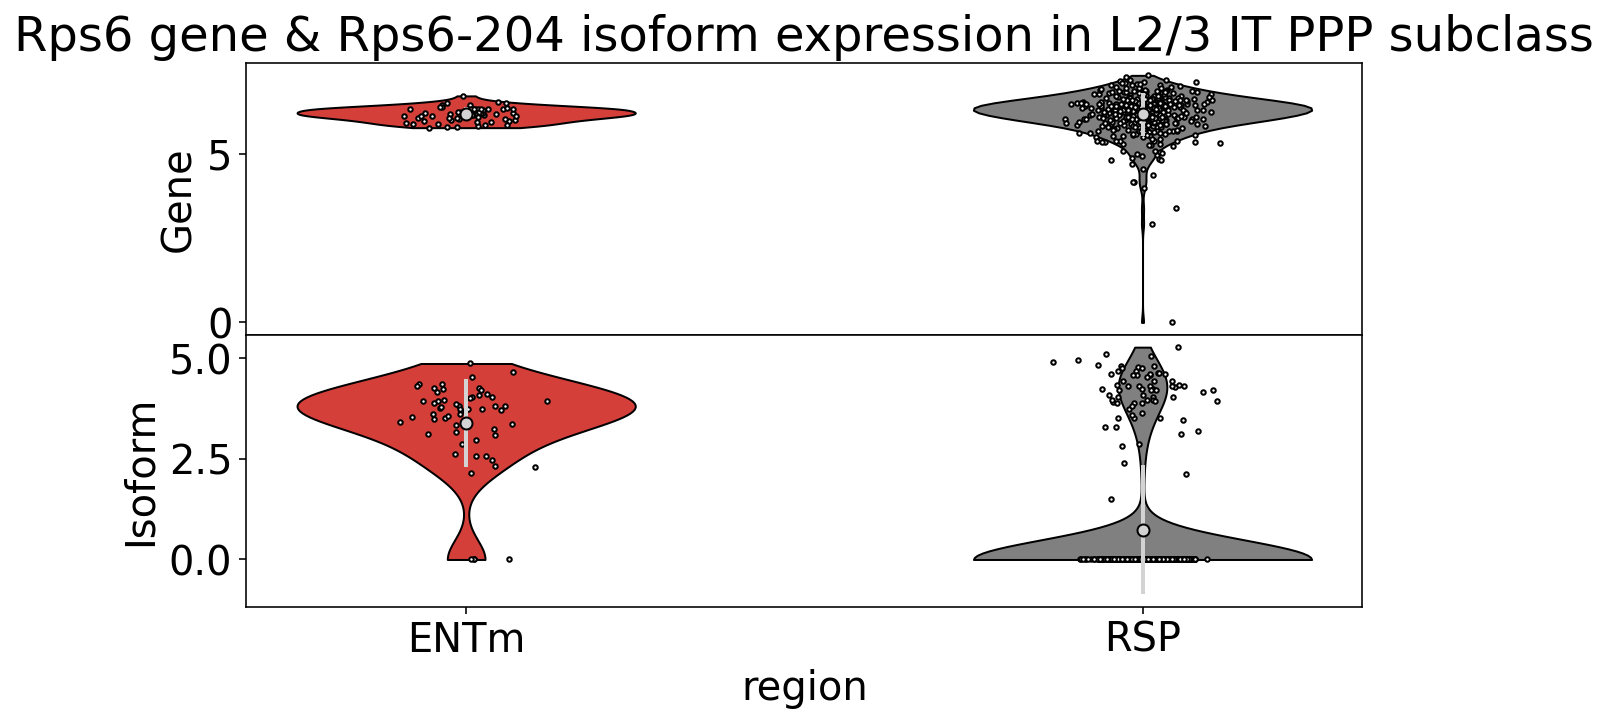

In [47]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

#mask = np.logical_and(gene.obs.subclass_label == specific_subclass, np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic"))
#c_gene = gene[mask]
#c_isoform = isoform[mask]
c_gene = gene_f
c_isoform = isoform_f
# Declare
unique = np.unique(c_gene.obs.region_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.delete(unique, np.where(unique=="Non-Neuronal"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_region)[0][0]
#plt.xticks(rotation=270)
plt.xlabel("region")

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(c_gene[c_gene.obs.region_label==c][:,c_gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)

# Isoform
x = []
for c in unique:
    x.append(np.asarray(c_isoform[c_isoform.obs.region_label==c][:,c_isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)
## Style
ax[0].set(**{
    "title":"{} gene & {} isoform expression in {} subclass".format(specific_gene.split("_")[0], specific_isoform.split("_")[0],specific_subclass),
    "ylabel":"Gene",
})

#need to figure out what ax[0] and ax[1] are
ymin, ymax = ax[1].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform",
    "ylim": (ymin, ymax),
})

plt.savefig("../../figures/region_subclass_DE_violin_all.png", bbox_inches='tight',dpi=300)
plt.show()

# gene.obs

In [48]:
#c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
isoform[:, isoform.var.transcript_name==specific_isoform]

View of AnnData object with n_obs × n_vars = 18175 × 1
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'log1p', 'norm', 'raw', 'scaled'
    obsp: 'connectivities', 'distances'

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not [(0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, nan, nan, nan, nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, nan, (0.8, 0.8, 0.8, 1.0), nan, nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, nan, (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), nan, nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), nan, nan, (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), nan, nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), nan, (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0), (0.8, 0.8, 0.8, 1.0)]

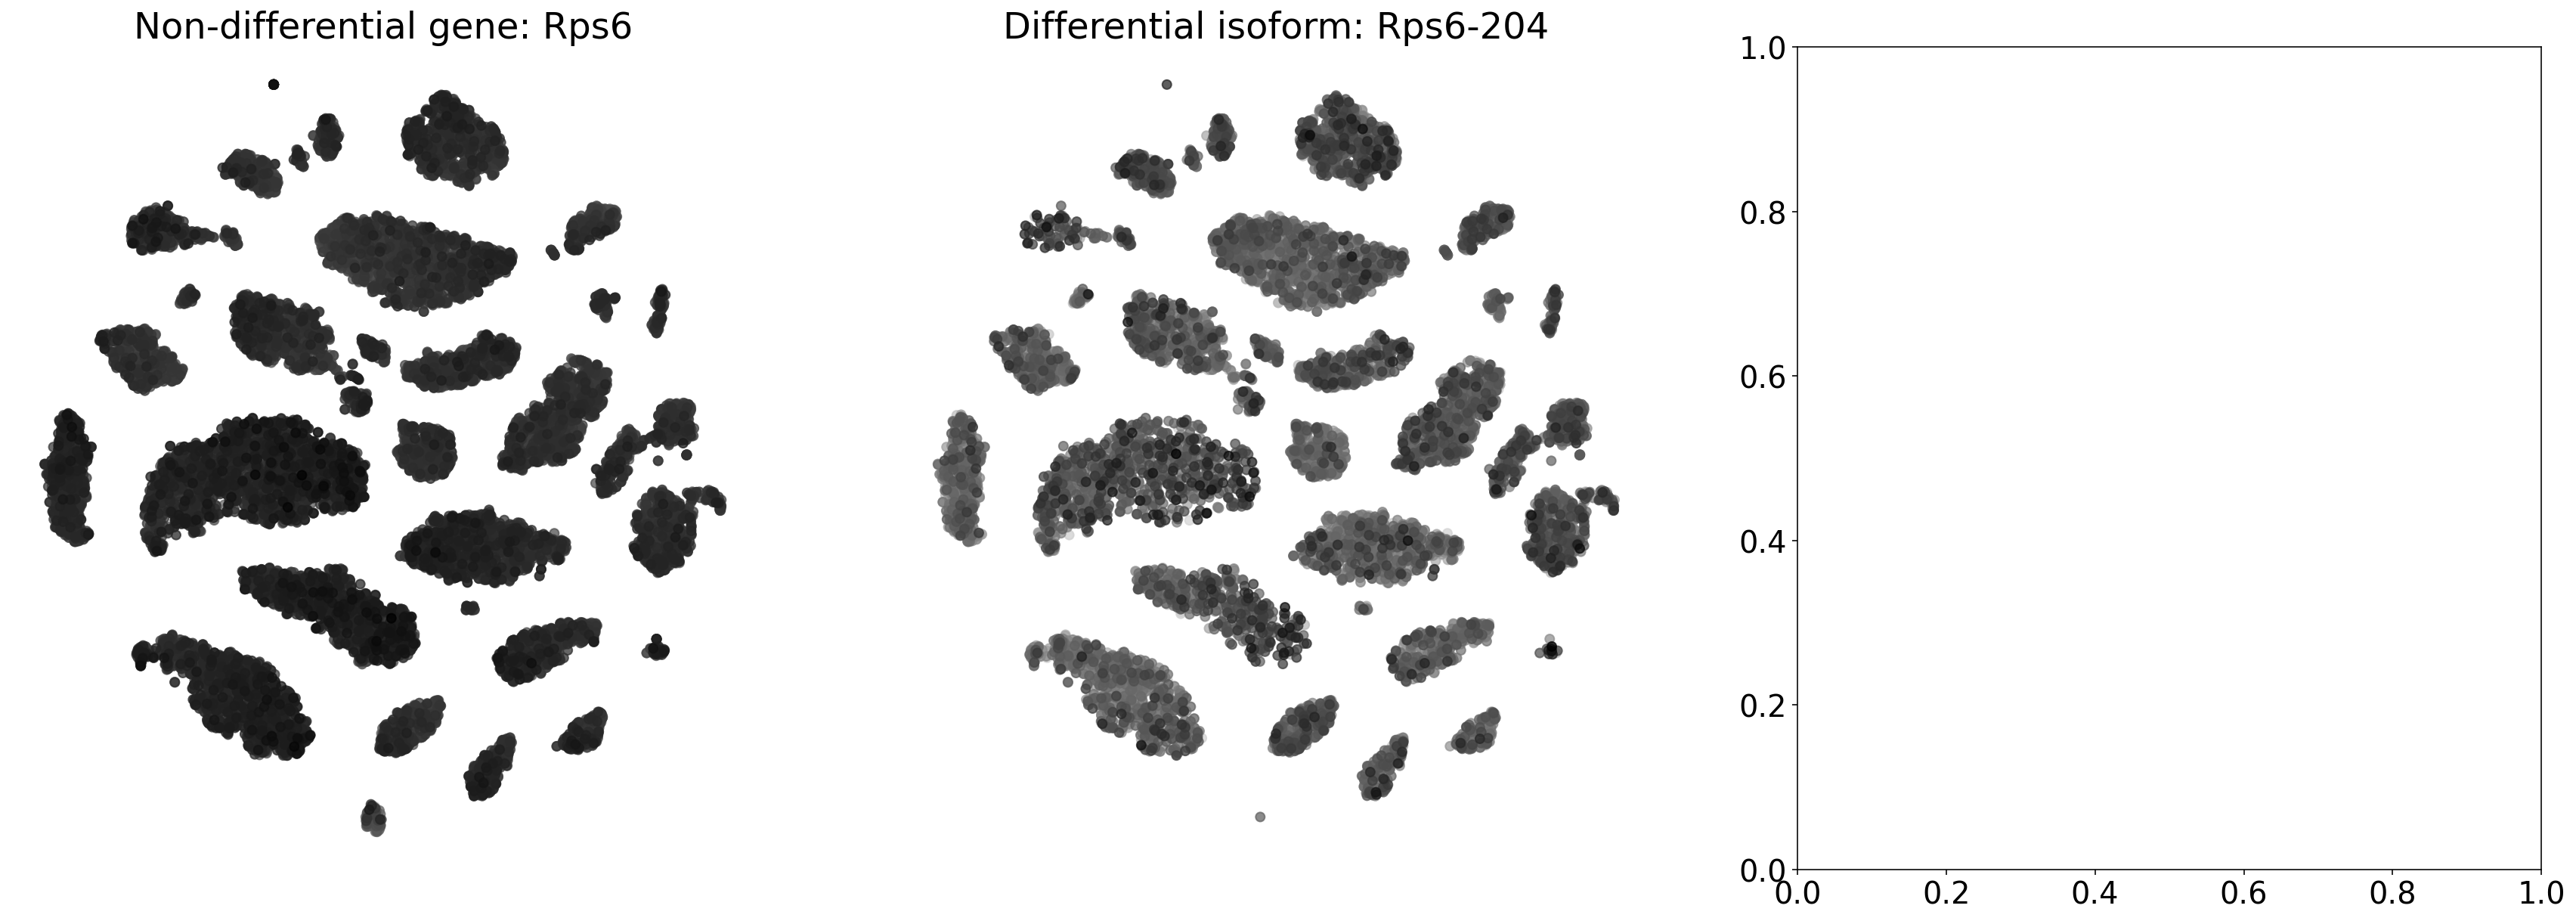

In [49]:
#this figure doesnt really make sense to be used
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_region
c = gene.obs["subclass_label"].astype(str).map(subclass_cmap).tolist()
indices = np.where(np.logical_or(gene.obs["region_label"]!=specific_region, gene.obs["subclass_label"]!=specific_subclass))[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Region: {} subclass: {}".format(specific_region,specific_subclass))
plt.savefig("../../figures/region_subclass_DE_nca_all.png", bbox_inches='tight',dpi=300)
plt.show()

In [ ]:
identified_isoforms = markers_isoform["name"].explode().astype(str)

In [ ]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [ ]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

In [ ]:
markers_isoform.to_csv("../../tables/unordered/region_subclass_DE_TEST.csv")